In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


Bad key "text.kerning_factor" on line 4 in
C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
path_demo = 'C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/demographic_info.txt'

In [3]:
df_demo = pd.read_csv('C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/demographic_info.txt', names = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                             delimiter = ' ')
df_demo.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [4]:
path_diag = 'C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/patient_diagnosis.csv'
df_diag = pd.read_csv(path_diag, names = ['Patient number', 'Diagnosis'])
df_diag.head()

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [5]:
df =  df_demo.join(df_diag.set_index('Patient number'), on = 'Patient number', how = 'left')
df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [6]:
path_data = 'C:/Users/Setareh Erfani/Desktop/Respiratory_Sound_Database/audio_and_txt_files'

In [7]:
import os
from os import listdir
from os.path import isfile
from os.path import join

filenames = [f for f in listdir(path_data) if (isfile(join(path_data, f)) and f.endswith('.wav'))] 
Txt_files = [f for f in listdir(path_data) if (isfile(join(path_data, f)) and f.endswith('.txt'))]

In [8]:
def Antn_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [9]:
tst_list = []
annotations = []
annotations_dict = {}
for kk in Txt_files:
    (i,a) = Antn_Data(kk, path_data)
    tst_list.append(i)
    annotations.append(a)
    annotations_dict[kk] = a
recording_info = pd.concat(tst_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,101,1b1,Al,sc,Meditron.txt
0,101,1b1,Pr,sc,Meditron.txt
0,102,1b1,Ar,sc,Meditron.txt
0,103,2b2,Ar,mc,LittC2SE.txt
0,104,1b1,Al,sc,Litt3200.txt


In [10]:
duration_list = []
for i in range(len(annotations)):
    current = annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

longest cycle:16.163
shortest cycle:0.20000000000000284
mean cycle:2.7005090852420994
mean+std cycle:5.045407366007572


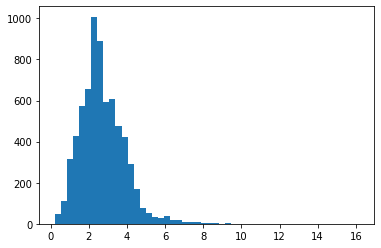

In [11]:
import matplotlib.pyplot as plt
duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
print('mean cycle:{}'.format(np.mean(duration_list)))
print('mean+std cycle:{}'.format(np.mean(duration_list)+2*np.std(duration_list)))

In [12]:
threshold =int(np.mean(duration_list)+2*np.std(duration_list))
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

Fraction of samples less than 5 seconds:0.9660771238040011


In [13]:
p_id_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_file.append(int(name[:3]))

p_id_file = np.array(p_id_file) 

p_id_cndt = {} # patient IDs corresponding to each file
for i in range(df_diag.shape[0]):
    for j in range(p_id_file.shape[0]):
        if p_id_file[j]==df_diag['Patient number'][i]:
            p_id_cndt[j]=df_diag['Diagnosis'][i]
                 
filepaths = [join(path_data, f) for f in filenames]

labels = np.array([df_diag[df_diag['Patient number'] == x]['Diagnosis'].values[0] for x in p_id_file]) # labels for audio files

In [14]:
N_Data={}
Env_data_spl={}
Row_data_spl={}
labels_new=[]
p_id_new=[]
p_cndt_new = []

len_sec=5
pcs=4

for i in range(920):

    for j in range(pcs):

        labels_new.append(labels[i])
        p_id_new.append(p_id_file[i])
        p_cndt_new.append(p_id_cndt[i])

p_id_new=np.array(p_id_new)
labels_new=np.array(labels_new)

In [15]:
def Unvr_FS(Features,label,N_F):
    
    X=Features
    y=label
    #Univariate Feature Selection
    # Split dataset to select feature and evaluate the classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=.75,
                                                        stratify=y, random_state=0)
    plt.figure(1)
    plt.clf()
    
    X_indices = np.arange(X.shape[-1])
    selector = SelectKBest(f_classif, N_F)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    features_score = scores/max(scores)

    # Compare to the weights of an SVM
    clf = make_pipeline(MinMaxScaler(), LinearSVC())
    clf.fit(X_train, y_train)
    print('Classification accuracy befor univariate feature selection: {:.3f}'
          .format(clf.score(X_test, y_test)))
    pred_n = clf.predict(X_test)
    svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
    svm_weights /= svm_weights.sum()
    svm_weights=svm_weights/max(svm_weights)
    plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='black', edgecolor='black')
    clf_selected = make_pipeline(SelectKBest(f_classif, N_F), MinMaxScaler(), LinearSVC())
    clf_selected.fit(X_train, y_train)
    pred_fs = clf_selected.predict(X_test)
    print('Classification accuracy after univariate feature selection: {:.3f}'
          .format(clf_selected.score(X_test, y_test)))
    svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
    svm_weights_selected /= svm_weights_selected.sum()
    svm_weights_selected=svm_weights_selected/max(svm_weights_selected)
    plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
            width=.2, label='SVM weights after selection', color='blue', edgecolor='blue')
    plt.title("Comparing feature selection")
    plt.xlabel('Feature index')
    plt.ylabel('Normalized feature Score')
    plt.yticks(())
    plt.axis('tight')
    plt.legend(loc='upper right')
    plt.show()
    
    return features_score,y_test,pred_n,pred_fs


In [16]:
path='C:/Users/Setareh Erfani/Desktop/S_features_s.xlsx'
S_features_s=pd.read_excel(path)
S_features_s=S_features_s.iloc[:,1:S_features_s.shape[1]]
S_features_s=S_features_s.values

In [17]:
goal_features=S_features_s
goal_labels=np.array(labels_new)

In [18]:
c_names = [ 'Bronchiectasis','Bronchiolitis', 'COPD', 'Healthy' ,'Pneumonia', 'URTI']
num_clss = len(c_names)

In [19]:
goal_features = np.delete(goal_features, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0) 
goal_labels = np.delete(goal_labels, np.where((goal_labels == 'Asthma') | (goal_labels == 'LRTI'))[0], axis=0)

In [20]:
le = LabelEncoder()
i_labels = le.fit_transform(goal_labels)

C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [403 787] are constant.
  UserWarning)
C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification accuracy befor univariate feature selection: 0.903


C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [403 787] are constant.
  UserWarning)
C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Setareh Erfani\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Classification accuracy after univariate feature selection: 0.899


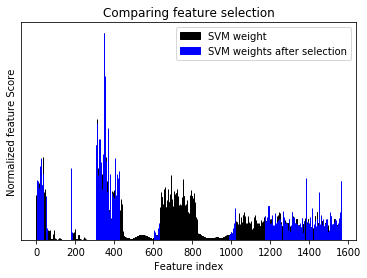

In [21]:
feat_score,y_test,pred_n,pred_fs=Unvr_FS(goal_features,i_labels,500)

In [22]:
print(confusion_matrix(y_test, pred_n))
print(confusion_matrix(y_test, pred_fs))

[[ 10   0   5   0   0   1]
 [  0   4   3   2   1   3]
 [  0   0 776   4  13   0]
 [  0   1  12  17   2   3]
 [  0   0  21   4  11   1]
 [  0   3   2   6   2  10]]
[[ 12   0   2   1   0   1]
 [  0   3   3   2   1   4]
 [  0   0 774   3  15   1]
 [  0   2  12  16   3   2]
 [  0   0  19   4  13   1]
 [  0   1   3  10   3   6]]


In [23]:
Oh_pred_n = to_categorical(pred_n) 
Oh_pred_fs = to_categorical(pred_fs) 
Oh_true = to_categorical(y_test) 


In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [26]:
from sklearn.metrics import classification_report

# Classification Report
classification_results=sklearn.metrics.classification_report(y_test, pred_fs, target_names=c_names)
print(sklearn.metrics.classification_report(y_test, pred_fs, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.75      0.86        16
 Bronchiolitis       0.50      0.23      0.32        13
          COPD       0.95      0.98      0.96       793
       Healthy       0.44      0.46      0.45        35
     Pneumonia       0.37      0.35      0.36        37
          URTI       0.40      0.26      0.32        23

      accuracy                           0.90       917
     macro avg       0.61      0.50      0.54       917
  weighted avg       0.89      0.90      0.89       917

